In [11]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import conversion_equations as ce
import pickle
import os
from matplotlib.colors import Normalize
import ast

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)
flags_df = flags_df[flags_df['include']]

In [12]:
# show all possible targets
TF_flags_df = pd.read_csv('../data/TF_flags_expanded.csv', index_col = 0)
keep = set()
for index, row in TF_flags_df.iterrows():
    for effector in ast.literal_eval(row['effectors']):
        if effector in starve_metabs.index:
            keep.add(index)
TF_flags_df.loc[list(keep)].sort_index()

,TF,gene_name,effectors,cAct_no_effector_form,cAct_multi_effector_binding,cAct_multi_co_effector_binding,cInh_no_effector_form,cInh_multi_effector_binding,cInh_multi_co_effector_binding,kd_inh_metab_up,kd_inh_metab_lo,kd_act_metab_up,kd_act_metab_lo
Arginine,argR,b3237,['Arginine'],0.0,1.0,0.0,0.0,1.0,0.0,0.031863,4.029000e-07,0.031863,4.029000e-07
Cra,cra,b0080,"['FructoseN/A1,6N/ABisphosphate']",0.0,1.0,0.0,0.0,1.0,0.0,0.254328,2.831000e-07,0.254328,2.831000e-07
Crp-1,crp,b3357,['AcetylN/ACoA'],0.0,1.0,0.0,0.0,1.0,0.0,0.150544,1.382500e-07,0.150544,1.382500e-07
Crp-2,crp,b3357,['AcetylN/ACoA'],0.0,1.0,0.0,0.0,1.0,0.0,0.150544,1.382500e-07,0.150544,1.382500e-07
Cysteine-1,cysB,b1275,['Serine'],0.0,1.0,0.0,0.0,1.0,0.0,0.124349,1.662050e-06,0.124349,1.662050e-06
Cysteine-2,cysB,b1275,['Serine'],0.0,1.0,0.0,0.0,1.0,0.0,0.124349,1.662050e-06,0.124349,1.662050e-06
Fatty Acid,fadR,b1187,['AcetylN/ACoA'],0.0,1.0,0.0,0.0,1.0,0.0,0.150544,1.382500e-07,0.150544,1.382500e-07
Lrp,lrp,b0889,['Leucine/Isoleucine'],0.0,1.0,0.0,0.0,1.0,0.0,0.193238,1.327000e-06,0.193238,1.327000e-06
Lysine/T2SS,argP,b2916,"['Aginine', 'Leucine/Isoleucine']",0.0,0.0,1.0,0.0,0.0,1.0,0.193238,1.327000e-06,0.193238,1.327000e-06
Purine,purR,b1658,"['Guanine', 'Hypoxanthine']",0.0,0.0,1.0,0.0,0.0,1.0,0.048076,4.795000e-08,0.048076,4.795000e-08


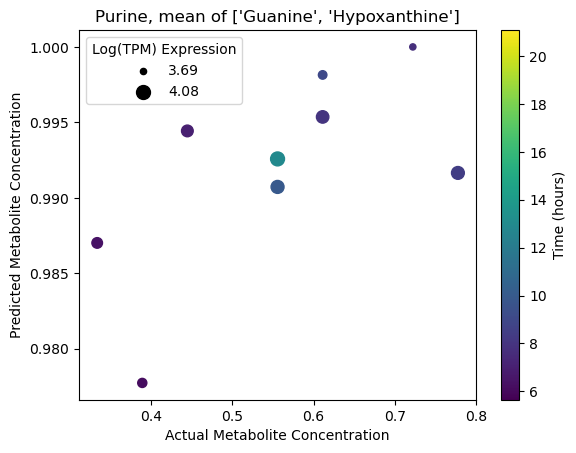

In [15]:
# let's also do the resulting metabolite concentration plots
# conversion to metabolite total concentration

# settings
case = 'Purine'#'Crp-2___DhaR'
color_by = 'time' # time, rsd
min_size = 20
max_size = 100
cols_use = 'starved' # starved, fed, all (all)
compare_percentiles_or_actual = '%ile' # %ile, actual
multi_metabolites_mean_or_index = 'mean' # mean, 0, 1
interactive = False

if True:
    #metabolites = ['Arginine']#['Guanine', 'Hypoxanthine']
    metabolites = ast.literal_eval(TF_flags_df.loc[case.split('___')[0]]['effectors'])
    
    if True: # setup/loading for run
        fed = ['starve_series__t00_growth1',
            'starve_series__t01_starve',
            'starve_series__t22_growth2',
            'starve_series__t23_growth2',
            'starve_series__t27_growth2',
            'starve_series__t28_growth2',]
        starved = ['starve_series__t02_starve',
         'starve_series__t03_starve',
         'starve_series__t06_starve',
         #'starve_series__t07_starve',
         #'starve_series__t08_starve',
         'starve_series__t09_starve',
         'starve_series__t10_starve',
         'starve_series__t11_starve',
         'starve_series__t12_starve',
         'starve_series__t14_starve',
         #'starve_series__t16_starve',
         #'starve_series__t17_starve',
         'starve_series__t18_starve',]

        if cols_use == 'all':
            cols_use = fed+starved
        elif cols_use == 'fed':
            cols_use = fed
        elif cols_use == 'starved':
            cols_use = starved

        times = 't0_1	t1_1	t2_1	t3_1	t4_1	t5_1	t6_1	t7_1	t8_1	t9_1	t10_1	t11_1	t12_1	t13_1	t14_1	t15_1	t16_1	t17_1	t18_1	t19_1	t20_1	t21_1	t22_1	t23_1	t24_1	t25_1	t26_1	t27_1	t28_1	t29_1	t30_1	t31_1	t32_1	t33_1	t34_1'
        hours = '5.65	6.07	6.15	6.38	6.48	6.73	6.98	7.23	7.48	7.73	7.98	8.48	8.98	9.48	9.98	10.48	10.98	11.98	12.98	13.98	14.98	15.98	16.98	17.98	18.18	18.28	18.42	18.58	18.83	19.08	19.33	19.58	20.08	20.58	21.08'
        time_to_hours = {k.split('_')[0] : float(v)-5.65 for k, v in zip(times.split('\t'), hours.split('\t'))}

        # load in relevant data
        starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
        # above is in (µM) , convert to M
        starve_metabs[starve_metabs.columns[1:]] *= 1e-6
        starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
        #starve_cols = list(set(starve_log_tpm.columns).intersection(actual_df.columns))

        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        mRNA_ratio_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        metab_df = inh_metab_df[inh_metab_df['iM'] == case]

        cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
        cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)

    if compare_percentiles_or_actual == 'actual':
        metabs_df = starve_metabs[cols_use]
    else:
        metabs_df = starve_metabs[cols_use].rank(axis = 1) / len(cols_use)

    # plotting
    iMs = case.split('___')
    for iM in iMs:
        metabolites = ast.literal_eval(TF_flags_df.loc[iM]['effectors'])
        if len(metabolites) == 0:
            continue
        # grab genes
        g1 = cAct_mapping[cAct_mapping[iM] != 0].index.to_list()
        g2 = cInh_mapping[cInh_mapping[iM] != 0].index.to_list()
        genes = list(set(g1).union(g2))

        gene = genes[0]

        # settings

        # pull predicted values
        if len(g2) > len(g1): # inhibitor
            pred_metab_df = inh_metab_df[inh_metab_df['iM'] == iM]
        else:
            pred_metab_df = act_metab_df[act_metab_df['iM'] == iM]
        if compare_percentiles_or_actual != 'actual':
            pred_metab_df['Val'] = pred_metab_df['Val'].rank() / len(pred_metab_df.index)

        rsd_df = pd.read_csv('../data/validation_data_sets/stationary_phase/rsd_df.csv', index_col = 0)
        def map_value_to_color(value, vmin, vmax, colormap_name):
            # Normalize the value to be between 0 and 1
            normalized_value = (value - vmin) / (vmax - vmin)

            # Ensure the normalized value is within the [0, 1] range
            normalized_value = np.clip(normalized_value, 0, 1)

            # Get the colormap
            colormap = plt.get_cmap(colormap_name)

            # Map the normalized value to a color from the colormap
            color = colormap(normalized_value)

            # Convert the RGBA color to a hex representation
            hex_color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

            return hex_color
        if color_by == 'time':
            min_t = min(time_to_hours.values())
            max_t = max(time_to_hours.values())
        elif color_by == 'rsd':
            min_t = min(rsd_df[cols_use].loc[metabolites].sum())
            max_t = max(rsd_df[cols_use].loc[metabolites].sum())

        min_exp = min(starve_log_tpm.loc[gene][cols_use])
        max_exp = max(starve_log_tpm.loc[gene][cols_use])



        fig, ax = plt.subplots()
        labels = []
        colors = []
        sizes = []
        for col in cols_use:
            size_pct = (starve_log_tpm.loc[gene][col] - min_exp) / (max_exp - min_exp)
            size = size_pct * (max_size - min_size) + min_size
            if color_by == 'time':
                val = time_to_hours['t'+str(int(col.split('__t')[1].split('_')[0]))]
            elif color_by == 'rsd':
                val = rsd_df[col].loc[metabolites].mean()
            color = map_value_to_color(val, min_t, max_t, 'viridis')
            colors.append(color)
            sizes.append(size)
            labels.append(col)
        if multi_metabolites_mean_or_index == 'mean':
            scatter = ax.scatter(metabs_df.loc[metabolites][cols_use].mean(), pred_metab_df.loc[cols_use]['Val'], s = sizes, c = colors)
        else:
            scatter = ax.scatter(metabs_df.loc[metabolites[multi_metabolites_mean_or_index]][cols_use], pred_metab_df.loc[cols_use]['Val'], s = sizes, c = colors)
        ax.set_ylabel('Predicted Metabolite Concentration')
        ax.set_xlabel('Actual Metabolite Concentration')

        # Create a ScalarMappable object for the color mapping
        norm = Normalize(vmin=min_t, vmax=max_t)
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])  # Fake a normalization array

        # Add colorbar
        if color_by == 'time':
            cbar = plt.colorbar(sm, ax = ax, label='Time (hours)')
        else:
            cbar = plt.colorbar(sm, ax = ax, label='Relative Std Dev of Metabolite Msmts')

        # Create custom legend
        legend_labels = ['{:.2f}'.format(min_exp), '{:.2f}'.format(max_exp)]
        legend_markers = [plt.scatter([], [], c = 'k', s=min_size),
                          plt.scatter([], [], c = 'k', s=max_size)]
        plt.legend(legend_markers, legend_labels, title='Log(TPM) Expression', loc='upper left')


        # make it pretty
        if len(metabolites) == 1:
            plt.title(iM+', '+metabolites[0])
        else:
            if multi_metabolites_mean_or_index == 'mean':
                plt.title(iM+', mean of '+str(metabolites))
            else:
                plt.title(iM+', '+str(metabolites[multi_metabolites_mean_or_index]))
        plt.savefig('../figures/'+iM+'_metabolite_validation.pdf', transparent = True)
        plt.show()

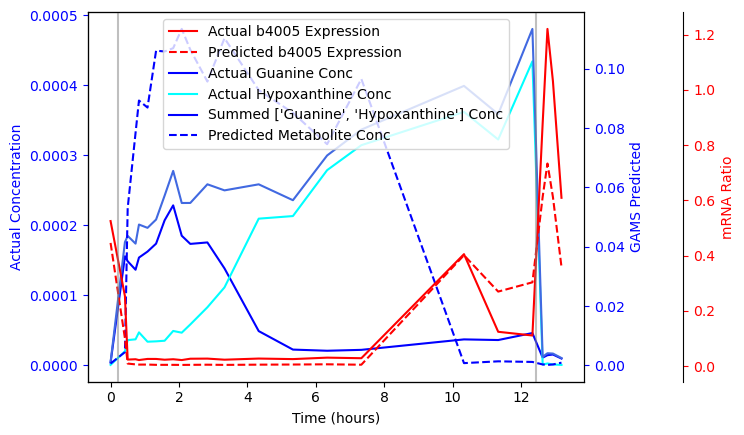

In [36]:
# plotting 

# settings
include_GAMS_predicted = True
third_axis_expression = True
gene_use = genes[0]
sum_or_indiv_metabs = 'sum'
if True:
    actual_ratio = ce.log_tpm_df_to_mRNA_ratio_df(log_tpm_df.loc[genes], flags_df).T
    
    metabolites = ast.literal_eval(TF_flags_df.loc[case.split('___')[0]]['effectors'])
    if include_GAMS_predicted:
        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        pred_log_tpm = ce.mRNA_ratio_df_to_log_tpm_df(mRNA_ratio_df, flags_df, log_tpm_df).T
        mRNA_df = mRNA_df.T
        metab_df = inh_metab_df[inh_metab_df['iM'] == case]
    
    times = 't0_1	t1_1	t2_1	t3_1	t4_1	t5_1	t6_1	t7_1	t8_1	t9_1	t10_1	t11_1	t12_1	t13_1	t14_1	t15_1	t16_1	t17_1	t18_1	t19_1	t20_1	t21_1	t22_1	t23_1	t24_1	t25_1	t26_1	t27_1	t28_1	t29_1	t30_1	t31_1	t32_1	t33_1	t34_1'
    hours = '5.65	6.07	6.15	6.38	6.48	6.73	6.98	7.23	7.48	7.73	7.98	8.48	8.98	9.48	9.98	10.48	10.98	11.98	12.98	13.98	14.98	15.98	16.98	17.98	18.18	18.28	18.42	18.58	18.83	19.08	19.33	19.58	20.08	20.58	21.08'
    time_to_hours = {k.split('_')[0] : float(v)-5.65 for k, v in zip(times.split('\t'), hours.split('\t'))}

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    if third_axis_expression:
        ax3 = ax1.twinx()
    metab_colors = ['blue', 'cyan']
    if len(metabolites) >= 1:
        for metabolite, color in zip(metabolites, metab_colors):
            x_vals = []
            y_vals = []
            time_to_vals = {}
            for sample, val in starve_metabs.loc[metabolite][1:].items():
                tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
                x_vals.append(time_to_hours[tim])
                y_vals.append(val)
                if time_to_hours[tim] not in time_to_vals:
                    time_to_vals.update({time_to_hours[tim] : []})
                time_to_vals[time_to_hours[tim]].append(val)
            ax1.plot(x_vals, y_vals, label = metabolite, c = color)
    if sum_or_indiv_metabs == 'sum':
        x_vals = []
        y_vals = []
        time_to_vals = {}
        for sample, val in starve_metabs.loc[metabolites][starve_metabs.columns[1:]].sum().items():
            tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
            x_vals.append(time_to_hours[tim])
            y_vals.append(val)
            if time_to_hours[tim] not in time_to_vals:
                time_to_vals.update({time_to_hours[tim] : []})
            time_to_vals[time_to_hours[tim]].append(val)
        ax1.plot(x_vals, y_vals, label = metabolite, c = 'royalblue')
    if include_GAMS_predicted:
        x_vals = []
        y_vals = []
        y_vals2 = []
        y_vals3 = []
        for sample, _ in starve_metabs.loc[metabolite][1:].items():
            if sample in metab_df.index:
                tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
                x_vals.append(time_to_hours[tim])
                y_vals.append(metab_df.loc[sample].Val)
                if third_axis_expression:
                    y_vals2.append(actual_ratio[sample].loc[gene_use])
                    y_vals3.append(mRNA_df[sample].loc[gene_use])
        ax2.plot(x_vals, y_vals, label = 'GAMS Predicted', ls = '--', c = 'blue')
        if third_axis_expression:
            ax3.plot(x_vals, y_vals2, label = gene_use+'Actual Expression', c = 'red')
            ax3.plot(x_vals, y_vals3, label = gene_use+'Pred Expression', ls = '--', c = 'red')
    ax1.set_ylabel('Actual Concentration')
    ax2.set_ylabel('GAMS Predicted')
    ax1.set_xlabel('Time (hours)')
    ax1.yaxis.label.set_color('Blue')
    ax1.tick_params(axis='y', colors = 'Blue')
    ax2.yaxis.label.set_color('Blue')
    ax2.tick_params(axis='y', colors = 'Blue')
    if third_axis_expression:
        ax3.set_ylabel('mRNA Ratio')
        ax3.spines.right.set_position(('axes', 1.2))
        ax3.yaxis.label.set_color('red')
        ax3.tick_params(axis='y', colors = 'red')
    plt.axvline(x = np.mean([5.65-5.65, 6.07-5.65]), c = 'grey', alpha = 0.5)
    plt.axvline(x = np.mean([17.98-5.65, 18.18-5.65]), c = 'grey',  alpha = 0.5)
    


    # Create dummy plot
    plt.plot([], [], color='red', linestyle='-', label='Solid Red')
    plt.plot([], [], color='blue', linestyle='-', label='Solid Blue')
    plt.plot([], [], color='red', linestyle='--', label='Dashed Red')
    plt.plot([], [], color='blue', linestyle='--', label='Dashed Blue')

    # Create custom legend handles
    legend_handles = []
    solid_red = mlines.Line2D([], [], color='red', linestyle='-', label='Actual '+gene_use+' Expression')
    dashed_red = mlines.Line2D([], [], color='red', linestyle='--', label='Predicted '+gene_use+' Expression')
    legend_handles.append(solid_red)
    legend_handles.append(dashed_red)
    if len(metabolites) >= 1:
        for metabolite, color in zip(metabolites, metab_colors):
            solid_blue = mlines.Line2D([], [], color=color, linestyle='-', label='Actual '+metabolite+' Conc')
            legend_handles.append(solid_blue)
    if sum_or_indiv_metabs == 'sum':
        solid_blue = mlines.Line2D([], [], color='blue', linestyle='-', label='Summed '+str(metabolites)+' Conc')
        legend_handles.append(solid_blue)
    dashed_blue = mlines.Line2D([], [], color='blue', linestyle='--', label='Predicted Metabolite Conc')
    legend_handles.append(dashed_blue)

    # Create legend
    plt.legend(handles=legend_handles, loc='best')
    
    plt.savefig('../figures/metabolite_conc.pdf', transparent = True)
    plt.show()

metabolites

,starve_series__t00_growth1,starve_series__t01_starve,starve_series__t02_starve,starve_series__t03_starve,starve_series__t04_starve,starve_series__t05_starve,starve_series__t06_starve,starve_series__t07_starve,starve_series__t08_starve,starve_series__t09_starve,...,starve_series__t16_starve,starve_series__t17_starve,starve_series__t18_starve,starve_series__t21_growth2,starve_series__t22_growth2,starve_series__t23_growth2,starve_series__t25_growth2,starve_series__t26_growth2,starve_series__t27_growth2,starve_series__t28_growth2
Compound,,,,,,,,,,,,,,,,,,,,,
Guanine,4.025000e-06,0.000156,0.000149,0.000137,0.000154,0.000163,0.000174,0.000207,0.000229,0.000185,...,0.000023,0.000021,0.000022,0.000037,0.000036,0.000046,0.000011,0.000015,0.000016,9.835000e-06
Hypoxanthine,7.700000e-07,0.000020,0.000036,0.000037,0.000047,0.000034,0.000034,0.000035,0.000049,0.000047,...,0.000213,0.000279,0.000315,0.000362,0.000323,0.000434,0.000001,0.000003,0.000001,7.250000e-07


In [41]:
import matplotlib.lines as mlines